# Trim Envelope

Calculate the set of trim points for an aircraft over a range of airspeeds
and range of flight path angles $\gamma$. The required thrust and AoA is
indicated via a colormap for each trim point.

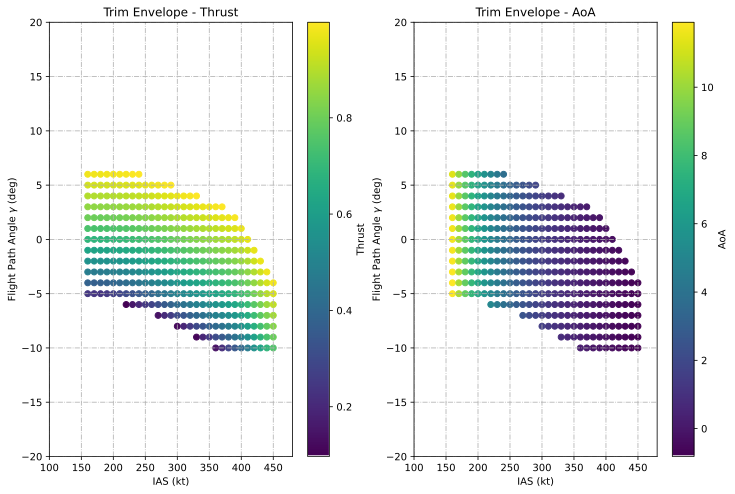

In [1]:
import jsbsim
import matplotlib.pyplot as plt
import math

# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="737"
# Path to JSBSim files, location of the folders "aircraft", "engines" and "systems"
PATH_TO_JSBSIM_FILES="../.."

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)

# Load the aircraft model
fdm.load_model(AIRCRAFT_NAME)

# Set engines running
fdm['propulsion/set-running'] = -1

# Set alpha range for trim solutions
fdm['aero/alpha-max-rad'] = math.radians(12)
fdm['aero/alpha-min-rad'] = math.radians(-4.0)

# Set envelope limits
min_speed = 120
max_speed = 460
altitude = 15000
min_gamma = -10
max_gamma = 10

# Trim results
results = []

# Iterate over a range of speeds and for each speed a range of flight path angles (gamma)
# and check whether a trim point is possible
for speed in range(min_speed, max_speed, 10):
    for gamma in range(min_gamma, max_gamma, 1):
        fdm['ic/h-sl-ft'] = altitude
        fdm['ic/vc-kts'] = speed
        fdm['ic/gamma-deg'] = gamma

        # Initialize the aircraft with initial conditions
        fdm.run_ic()

        # Trim
        try:
            fdm['simulation/do_simple_trim'] = 1
            results.append((fdm['velocities/vc-kts'], fdm['aero/alpha-deg'], gamma, fdm['fcs/throttle-cmd-norm[0]']))
        except jsbsim.TrimFailureError:
            pass  # Ignore trim failures

# Extract the trim results
speed, alpha, gamma, throttle = zip(*results)

plt.rcParams["figure.figsize"] = (12, 8)

# Plot the trim envelope results, with required thrust and AoA indicated via a colormap
fig, (axThrust, axAoA) = plt.subplots(1, 2)

# Graph data for each of the sub plots
graph_data = [ ('Thrust', axThrust, throttle), ('AoA', axAoA, alpha) ]

for title, ax, data in graph_data:
    # Scatter plot with airspeed on x-axis, gamma on y-axis and either thrust setting or
    # AoA indicated via color map
    scatter = ax.scatter(speed, gamma, c=data, cmap='viridis')
    cb = fig.colorbar(scatter, ax=ax)
    cb.set_label(title)

    # Graph axis range for speed and gamma
    ax.set_xlim(min_speed - 20, max_speed + 20)
    ax.set_ylim(min_gamma * 2, max_gamma * 2)

    ax.grid(True, linestyle='-.')

    ax.set_xlabel('IAS (kt)')
    ax.set_ylabel('Flight Path Angle $\gamma$ (deg)')
    ax.set_title(f'Trim Envelope - {title}')

plt.show()